# Making figures for the paper

## First figure, sample price data. 

In [2]:
# %load load_data.py
import numpy as np
import pandas as pd
import glob, os, re


# Read the data only once.  It's big!
csv_files = glob.glob(os.path.join(".", "data", "hft_data", "AAPL", "*_message_*.csv"))
date_str = re.compile(r'_(\d{4}-\d{2}-\d{2})_')
stock_str = re.compile(r'([A-Z]+)_\d{4}-\d{2}-\d{2}_')

df_list = []
day_list = []
sym_list = []

for csv_file in sorted(csv_files):
    date = date_str.search(csv_file)
    date = date.group(1)
    day_list.append(date)

    symbol = stock_str.search(csv_file)
    symbol = symbol.group(1)
    sym_list.append(symbol)

    # Find the order book file that matches this message file.
    book_file = csv_file.replace("message", "orderbook")

    # Read the message file and index by timestamp.
    df = pd.read_csv(csv_file, names=['Time','EventType','OrderID','Size','Price','Direction'])
    df['Time'] = pd.to_datetime(date) + pd.to_timedelta(df['Time'], unit='s')

    # Read the order book file and merge it with the messages.
    names = [f"{x}{i}" for i in range(1,11) for x in ["AP","AS","BP","BS"]]
    df = df.join(pd.read_csv(book_file, names=names), how='inner')
    df = df.set_index(['Time'])

    BBID_COL = df.columns.get_loc("BP1")
    BASK_COL = df.columns.get_loc("AP1")

    print (f"Read {df.shape[0]} unique order book shapshots from {csv_file}")

    df_list.append(df)

days = len(day_list)

Read 738034 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-01_34200000_57600000_message_10.csv
Read 1923409 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-04_34200000_57600000_message_10.csv
Read 2108353 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-05_34200000_57600000_message_10.csv
Read 2364167 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-06_34200000_57600000_message_10.csv
Read 1732063 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-07_34200000_57600000_message_10.csv
Read 3123866 unique order book shapshots from ./data/hft_data/AAPL/AAPL_2024-03-08_34200000_57600000_message_10.csv


In [3]:
def extract_pv(df):
    df = df[['Price', 'Size']]
    df.head()

    # sample every 100ms, and the size would be the sum of the size in that 100ms. 
    # Price would be the average price in that 100ms.
    df = df.resample('100ms').agg({'Price': 'mean', 'Size': 'sum'})

    # Check for NaN values

    # forwardfill all NaN values in the data
    df = df.ffill()

    # normalize the data with mean and std
    mean = df['Price'].mean()
    std = df['Price'].std()
    df['Price'] = (df['Price'] - mean) / std

    mean = df['Size'].mean()
    std = df['Size'].std()
    df['Size'] = (df['Size'] - mean) / std

    print("original shape: ", df.shape)
    return df

pv_list = [extract_pv(df) for df in df_list]

original shape:  (71999, 2)
original shape:  (234000, 2)
original shape:  (234000, 2)
original shape:  (234000, 2)
original shape:  (234000, 2)
original shape:  (234000, 2)


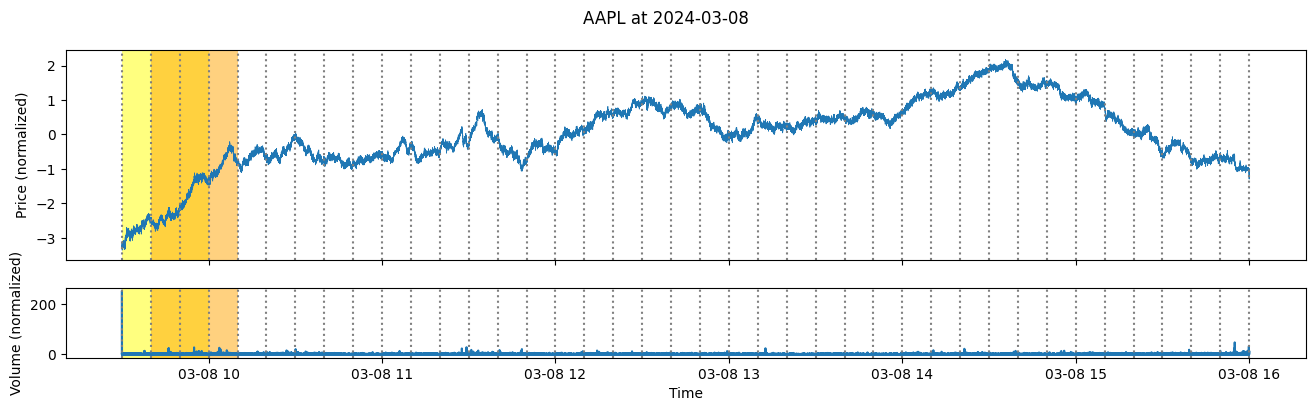

In [4]:
import matplotlib.pyplot as plt

# Create subplots with height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 4), gridspec_kw={'height_ratios': [3, 1]})

# Plot price as a line graph
ax1.plot(pv_list[5]['Price'], linewidth=0.5)
ax1.set_ylabel('Price (normalized)')

# Plot volume as a bar graph
ax2.plot(pv_list[5]['Size'])
ax2.set_ylabel('Volume (normalized)')

# Set x-axis label for the last subplot
ax2.set_xlabel('Time')

# Add vertical dotted lines every ten minutes
import datetime

# Convert 10 minutes to pandas timedelta
ten_minutes = pd.Timedelta(minutes=10)

# Get the start and end times of the plot
start_time = pv_list[5].index[0]
end_time = pv_list[5].index[-1]

# Calculate the number of ten-minute intervals between start and end times
num_intervals = int((end_time - start_time) / ten_minutes)

# Iterate over the intervals and add vertical lines
for i in range(num_intervals + 2):
    line_time = start_time + (i * ten_minutes)
    ax1.axvline(line_time, linestyle='dotted', color='gray')
    ax2.axvline(line_time, linestyle='dotted', color='gray')

# Highlight the first 40 minutes by changing the background color
ax1.axvspan(start_time, start_time + pd.Timedelta(minutes=30), facecolor='yellow', alpha=0.5)
ax2.axvspan(start_time, start_time + pd.Timedelta(minutes=30), facecolor='yellow', alpha=0.5)

ax1.axvspan(start_time+ pd.Timedelta(minutes=10), start_time + pd.Timedelta(minutes=40), facecolor='orange', alpha=0.5)
ax2.axvspan(start_time+ pd.Timedelta(minutes=10), start_time + pd.Timedelta(minutes=40), facecolor='orange', alpha=0.5)

# Adjust spacing between subplots
# plt.subplots_adjust(hspace=0.3)

# remove the x-axis label for the first subplot
plt.setp(ax1.get_xticklabels(), visible=False)

# Add a title
plt.suptitle('AAPL at 2024-03-08')



# Show the figure
plt.show()

In [5]:
start_time

Timestamp('2024-03-08 09:30:00')

# Figure for data processing

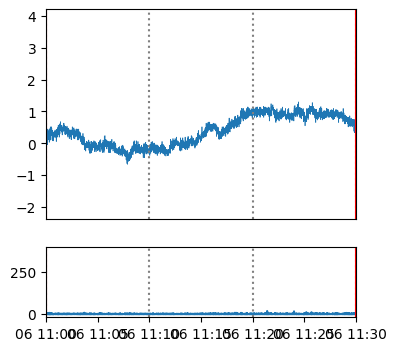

In [23]:
import matplotlib.pyplot as plt

# Create subplots with height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), gridspec_kw={'height_ratios': [3, 1]})

# Plot price as a line graph
ax1.plot(pv_list[3]['Price'], linewidth=0.5)
ax1.set_ylabel('Price (normalized)')

# Plot volume as a bar graph
ax2.plot(pv_list[3]['Size'])
ax2.set_ylabel('Volume (normalized)')

# Set x-axis label for the last subplot
ax2.set_xlabel('Time')

# Add vertical dotted lines every ten minutes
import datetime

# Convert 10 minutes to pandas timedelta
ten_minutes = pd.Timedelta(minutes=10)

# Get the start and end times of the plot
start_time = pv_list[3].index[0]
end_time = pv_list[3].index[-1]

# Calculate the number of ten-minute intervals between start and end times
num_intervals = int((end_time - start_time) / ten_minutes)

# Iterate over the intervals and add vertical lines
for i in range(num_intervals + 2):
    line_time = start_time + (i * ten_minutes)
    ax1.axvline(line_time, linestyle='dotted', color='gray')
    ax2.axvline(line_time, linestyle='dotted', color='gray')
    if i % 3 == 0: 
        ax1.axvline(line_time, linestyle='solid', color='red')
        ax2.axvline(line_time, linestyle='solid', color='red')

# # Highlight the first 40 minutes by changing the background color
# ax1.axvspan(start_time, start_time + pd.Timedelta(minutes=30), facecolor='pink', alpha=0.5)
# ax2.axvspan(start_time, start_time + pd.Timedelta(minutes=30), facecolor='pink', alpha=0.5)

# ax1.axvspan(start_time+ pd.Timedelta(minutes=30), start_time + pd.Timedelta(minutes=60), facecolor='red', alpha=0.5)
# ax2.axvspan(start_time+ pd.Timedelta(minutes=30), start_time + pd.Timedelta(minutes=60), facecolor='red', alpha=0.5)

# ax1.axvspan(start_time+ pd.Timedelta(minutes=60), start_time + pd.Timedelta(minutes=90), facecolor='yellow', alpha=0.5)
# ax2.axvspan(start_time+ pd.Timedelta(minutes=60), start_time + pd.Timedelta(minutes=90), facecolor='yellow', alpha=0.5)

# ax1.axvspan(start_time+ pd.Timedelta(minutes=90), start_time + pd.Timedelta(minutes=120), facecolor='green', alpha=0.5)
# ax2.axvspan(start_time+ pd.Timedelta(minutes=90), start_time + pd.Timedelta(minutes=120), facecolor='green', alpha=0.5)

# ax1.axvspan(start_time+ pd.Timedelta(minutes=120), start_time + pd.Timedelta(minutes=150), facecolor='lightblue', alpha=0.5)
# ax2.axvspan(start_time+ pd.Timedelta(minutes=120), start_time + pd.Timedelta(minutes=150), facecolor='lightblue', alpha=0.5)



# Adjust spacing between subplots
# plt.subplots_adjust(hspace=0.3)

# remove the x-axis label for the first subplot
plt.setp(ax1.get_xticklabels(), visible=False)

# Add a title
# plt.suptitle('AAPL at 2024-03-06 (Partially)')

# Set the x-axis limits
start_time = start_time.replace(hour=11, minute=00, second=0)
end_time = start_time.replace(hour=11, minute=30, second=0)
ax1.set_xlim(start_time, end_time)
ax2.set_xlim(start_time, end_time)

# remove all axis labels and title
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax1.set_title('')

# remove x ticks
ax1.set_xticks([])

# Show the figure
plt.show()

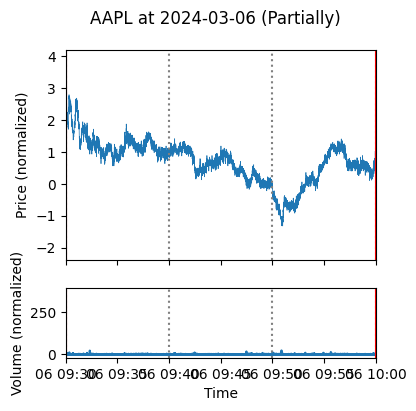

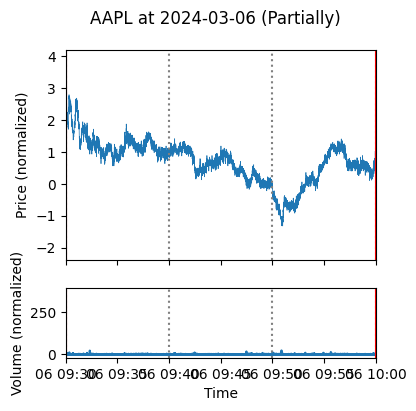

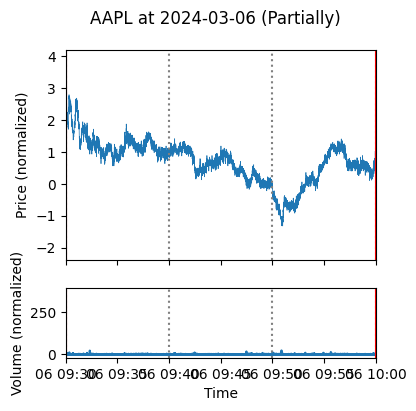

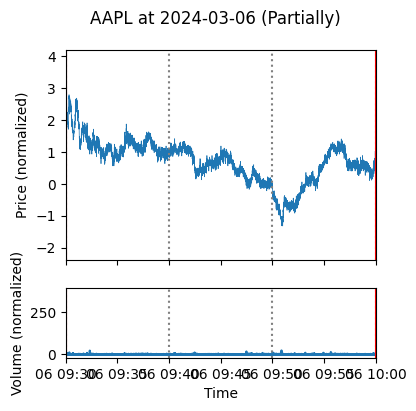

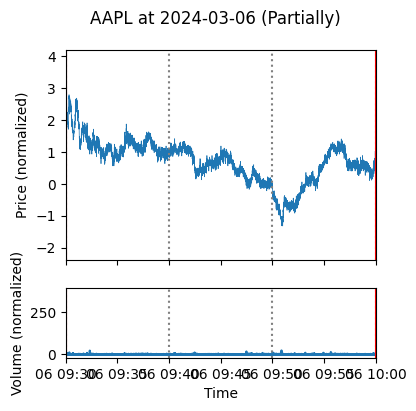

In [18]:

for i in range(5):
    # Create subplots with height ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4), gridspec_kw={'height_ratios': [3, 1]})

    # Plot price as a line graph
    ax1.plot(pv_list[3]['Price'], linewidth=0.5)
    ax1.set_ylabel('Price (normalized)')

    # Plot volume as a bar graph
    ax2.plot(pv_list[3]['Size'])
    ax2.set_ylabel('Volume (normalized)')

    # Set x-axis label for the last subplot
    ax2.set_xlabel('Time')

    # Add vertical dotted lines every ten minutes
    import datetime

    # Convert 10 minutes to pandas timedelta
    ten_minutes = pd.Timedelta(minutes=10)

    # Get the start and end times of the plot
    start_time = pv_list[3].index[0]
    end_time = pv_list[3].index[-1]

    # Calculate the number of ten-minute intervals between start and end times
    num_intervals = int((end_time - start_time) / ten_minutes)

    # Iterate over the intervals and add vertical lines
    for i in range(num_intervals + 2):
        line_time = start_time + (i * ten_minutes)
        ax1.axvline(line_time, linestyle='dotted', color='gray')
        ax2.axvline(line_time, linestyle='dotted', color='gray')
        if i % 3 == 0: 
            ax1.axvline(line_time, linestyle='solid', color='red')
            ax2.axvline(line_time, linestyle='solid', color='red')

    # # Highlight the first 40 minutes by changing the background color
    # ax1.axvspan(start_time, start_time + pd.Timedelta(minutes=30), facecolor='pink', alpha=0.5)
    # ax2.axvspan(start_time, start_time + pd.Timedelta(minutes=30), facecolor='pink', alpha=0.5)

    # ax1.axvspan(start_time+ pd.Timedelta(minutes=30), start_time + pd.Timedelta(minutes=60), facecolor='red', alpha=0.5)
    # ax2.axvspan(start_time+ pd.Timedelta(minutes=30), start_time + pd.Timedelta(minutes=60), facecolor='red', alpha=0.5)

    # ax1.axvspan(start_time+ pd.Timedelta(minutes=60), start_time + pd.Timedelta(minutes=90), facecolor='yellow', alpha=0.5)
    # ax2.axvspan(start_time+ pd.Timedelta(minutes=60), start_time + pd.Timedelta(minutes=90), facecolor='yellow', alpha=0.5)

    # ax1.axvspan(start_time+ pd.Timedelta(minutes=90), start_time + pd.Timedelta(minutes=120), facecolor='green', alpha=0.5)
    # ax2.axvspan(start_time+ pd.Timedelta(minutes=90), start_time + pd.Timedelta(minutes=120), facecolor='green', alpha=0.5)

    # ax1.axvspan(start_time+ pd.Timedelta(minutes=120), start_time + pd.Timedelta(minutes=150), facecolor='lightblue', alpha=0.5)
    # ax2.axvspan(start_time+ pd.Timedelta(minutes=120), start_time + pd.Timedelta(minutes=150), facecolor='lightblue', alpha=0.5)



    # Adjust spacing between subplots
    # plt.subplots_adjust(hspace=0.3)

    # remove the x-axis label for the first subplot
    plt.setp(ax1.get_xticklabels(), visible=False)

    # Add a title
    plt.suptitle('AAPL at 2024-03-06 (Partially)')

    # Set the x-axis limits based on i: 
    start_time = start_time.replace(hour=9, minute=30, second=0) # + pd.Timedelta(minutes=30*i)
    end_time = start_time.replace(hour=10, minute=00, second=0) # + pd.Timedelta(minutes=30*(i+1))
    ax1.set_xlim(start_time, end_time)
    ax2.set_xlim(start_time, end_time)

    # remove all texts and axis 
    ax1.set_title('')


    # Show the figure
    plt.show()

In [27]:
df_list[0].head(10)[["Price", "Size"]]

,Price,Size
Time,,
2024-03-01 09:30:00.002085965,1795700,300
2024-03-01 09:30:00.002125945,1796000,100
2024-03-01 09:30:00.002169958,1795700,465
2024-03-01 09:30:00.002240290,1795700,5
2024-03-01 09:30:00.002325540,1795800,100
2024-03-01 09:30:00.002424109,1795500,100
2024-03-01 09:30:00.002459979,1795700,5
2024-03-01 09:30:00.002459979,1795700,100
2024-03-01 09:30:00.002496786,1795700,5
